In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import datasets
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import sklearn
from sklearn.metrics import pairwise_distances_argmin_min

In [2]:
#Initialize SpotiPy with user credentias
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="",
                                                           client_secret=""))


In [3]:
#the playlists

old_song="6iEedN9Ob4fXHvhQ8OW2tq"

nintys_song="2yXkVph9Xavf21yowTVmBH"

new_song="1WgiJRlzI1GZIm1HE0pRZy"


In [4]:
#code to pass the 100 limit for the tracks got from the api

def get_all_tracks(playlist):
    results = sp.user_playlist_tracks("spotify", playlist)
    tracks = results['items'] 
    
    for oset in range(100,results['total'],100):
        results = sp.user_playlist_tracks("spotify", playlist, offset=oset)
        tracks += results['items']
    
    return tracks

all_old_song = get_all_tracks(old_song)
all_90s_song = get_all_tracks(nintys_song)
all_new_song = get_all_tracks(new_song)


In [5]:
# Getting all the artists

def get_artists_from_playlist(playlist_id, tracks):
    
    tracks_from_playlist = tracks
    
    artists = []
    
    for track in tracks_from_playlist:
        artist_info = track['track']['artists'][0]
        artists.append(artist_info['name'])
        
    return artists

all_artist_old_song = get_artists_from_playlist(old_song,all_old_song)
all_artist_90s_song = get_artists_from_playlist(nintys_song,all_90s_song)
all_artist_new_song = get_artists_from_playlist(new_song,all_new_song)

In [6]:
#get song names & track ids

def get_song_names(tracks):
    song_actual_names = [track['track']['name'] for track in tracks]
    track_ids = [track['track']['id'] for track in tracks]
    return song_actual_names,track_ids

song_names_old,id_track_old = get_song_names(all_old_song)
song_names_90s,id_track_90s = get_song_names(all_90s_song)
song_names_new,id_track_new = get_song_names(all_new_song)

In [7]:
#get all genres and popularity

def get_pop_and_genre(tracks):
    
    genre = []
    popularity = []
    
    for elem in tracks:
        artist01 = sp.artist(elem['track']["album"]["artists"][0]["external_urls"]["spotify"])
        genre.append(artist01["genres"][0] if artist01["genres"] else "genreless")
        popularity.append(artist01["popularity"])
        
        
    return genre,popularity

genre_old,popularity_old = get_pop_and_genre(all_old_song)
genre_90s,popularity_90s = get_pop_and_genre(all_90s_song)
genre_new,popularity_new = get_pop_and_genre(all_new_song)
genre_old

['classic bollywood',
 'classic bollywood',
 'chutney',
 'chutney',
 'classic bollywood',
 'chutney',
 'genreless',
 'genreless',
 'classic bollywood',
 'classic bollywood',
 'classic bollywood',
 'classic bollywood',
 'classic bollywood']

In [8]:
#gathering main features and turning them into a dataframe

def main_features_to_df(track_ids):
    the_list = []
    for i in track_ids:
        the_list.append(sp.audio_features(i))
    #looping inside the nested list to be able to convert into a df    
    converted = [i for elem in the_list for i in elem]    
    df = pd.json_normalize(converted)
    
    return df
        
df_old = main_features_to_df(id_track_old)
df_90s = main_features_to_df(id_track_90s)
df_new = main_features_to_df(id_track_new)
df_old 

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.355,0.278,2,-13.566,1,0.0455,0.960,0.138000,0.2390,0.722,70.791,audio_features,4v4wIJBIsNZedLRyFhpuBZ,spotify:track:4v4wIJBIsNZedLRyFhpuBZ,https://api.spotify.com/v1/tracks/4v4wIJBIsNZe...,https://api.spotify.com/v1/audio-analysis/4v4w...,328800,4
1,0.486,0.481,1,-9.418,1,0.0937,0.779,0.000000,0.0838,0.674,104.529,audio_features,3DP0p4eTxRIh4hMtwj8ALC,spotify:track:3DP0p4eTxRIh4hMtwj8ALC,https://api.spotify.com/v1/tracks/3DP0p4eTxRIh...,https://api.spotify.com/v1/audio-analysis/3DP0...,407973,4
2,0.493,0.604,1,-7.304,0,0.0455,0.989,0.655000,0.2420,0.716,95.966,audio_features,4YZJr7NL2fmZkPI3CXeNhV,spotify:track:4YZJr7NL2fmZkPI3CXeNhV,https://api.spotify.com/v1/tracks/4YZJr7NL2fmZ...,https://api.spotify.com/v1/audio-analysis/4YZJ...,228960,4
3,0.376,0.462,1,-9.545,0,0.0335,0.823,0.004000,0.1220,0.736,106.954,audio_features,5P49QyK81dOSc3W7iWDlAT,spotify:track:5P49QyK81dOSc3W7iWDlAT,https://api.spotify.com/v1/tracks/5P49QyK81dOS...,https://api.spotify.com/v1/audio-analysis/5P49...,216373,3
4,0.436,0.692,7,-7.410,0,0.0449,0.878,0.000241,0.1460,0.351,93.887,audio_features,3l7vUdzFY1zr2ilOVtukO8,spotify:track:3l7vUdzFY1zr2ilOVtukO8,https://api.spotify.com/v1/tracks/3l7vUdzFY1zr...,https://api.spotify.com/v1/audio-analysis/3l7v...,215267,4
5,0.549,0.653,7,-5.301,0,0.0279,0.429,0.000007,0.1150,0.582,125.266,audio_features,0e97hF1Fs0OBJnhfuddjE6,spotify:track:0e97hF1Fs0OBJnhfuddjE6,https://api.spotify.com/v1/tracks/0e97hF1Fs0OB...,https://api.spotify.com/v1/audio-analysis/0e97...,319019,4
6,0.466,0.452,6,-9.232,0,0.0321,0.678,0.000014,0.0581,0.882,126.696,audio_features,2QGilBp4UILvAbBwykuq7p,spotify:track:2QGilBp4UILvAbBwykuq7p,https://api.spotify.com/v1/tracks/2QGilBp4UILv...,https://api.spotify.com/v1/audio-analysis/2QGi...,261000,4
7,0.501,0.217,4,-12.355,0,0.0481,0.976,0.000002,0.1460,0.726,149.763,audio_features,5ZKMBzpA8E2dDOmL06pK3J,spotify:track:5ZKMBzpA8E2dDOmL06pK3J,https://api.spotify.com/v1/tracks/5ZKMBzpA8E2d...,https://api.spotify.com/v1/audio-analysis/5ZKM...,201160,3
8,0.395,0.547,3,-9.100,0,0.0931,0.956,0.039500,0.1190,0.588,80.219,audio_features,6DuEwqeZzkPJlczCKPq1VD,spotify:track:6DuEwqeZzkPJlczCKPq1VD,https://api.spotify.com/v1/tracks/6DuEwqeZzkPJ...,https://api.spotify.com/v1/audio-analysis/6DuE...,329275,4
9,0.558,0.824,1,-3.102,0,0.0363,0.657,0.000000,0.0846,0.781,138.656,audio_features,0afLBcNf0G0h2978Uhu8Px,spotify:track:0afLBcNf0G0h2978Uhu8Px,https://api.spotify.com/v1/tracks/0afLBcNf0G0h...,https://api.spotify.com/v1/audio-analysis/0afL...,297920,4


In [9]:
# adding previous single gathered features to the current df

def add_features_to_df(song_actual_names,artist_list,genre,popularity,features_df):
    df_song_name = pd.DataFrame(song_actual_names, columns = ["song_name"])
    df_artists = pd.DataFrame(artist_list,columns = ["artists"])
    df_genre = pd.DataFrame(genre,columns = ["genre"])
    df_popularity = pd.DataFrame(popularity,columns = ["popularity"])
    
    final_boss_df = pd.concat([features_df, df_song_name,df_artists,df_genre,df_popularity], axis=1)
    
    return final_boss_df

final_df_old = add_features_to_df(song_names_old,all_artist_old_song,genre_old,popularity_old,df_old)
final_df_90s = add_features_to_df(song_names_90s,all_artist_90s_song,genre_90s,popularity_90s,df_90s)
final_df_new = add_features_to_df(song_names_new,all_artist_new_song,genre_new,popularity_new,df_new)
final_df_old

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,id,uri,track_href,analysis_url,duration_ms,time_signature,song_name,artists,genre,popularity
0,0.355,0.278,2,-13.566,1,0.0455,0.960,0.138000,0.2390,0.722,...,4v4wIJBIsNZedLRyFhpuBZ,spotify:track:4v4wIJBIsNZedLRyFhpuBZ,https://api.spotify.com/v1/tracks/4v4wIJBIsNZe...,https://api.spotify.com/v1/audio-analysis/4v4w...,328800,4,Sawan Ka Mahina,Lata Mangeshkar,classic bollywood,61
1,0.486,0.481,1,-9.418,1,0.0937,0.779,0.000000,0.0838,0.674,...,3DP0p4eTxRIh4hMtwj8ALC,spotify:track:3DP0p4eTxRIh4hMtwj8ALC,https://api.spotify.com/v1/tracks/3DP0p4eTxRIh...,https://api.spotify.com/v1/audio-analysis/3DP0...,407973,4,Aaj Rapat Jaayen To,Kishore Kumar,classic bollywood,54
2,0.493,0.604,1,-7.304,0,0.0455,0.989,0.655000,0.2420,0.716,...,4YZJr7NL2fmZkPI3CXeNhV,spotify:track:4YZJr7NL2fmZkPI3CXeNhV,https://api.spotify.com/v1/tracks/4YZJr7NL2fmZ...,https://api.spotify.com/v1/audio-analysis/4YZJ...,228960,4,Bheegi Bheegi Raaton Mein,Lata Mangeshkar,chutney,66
3,0.376,0.462,1,-9.545,0,0.0335,0.823,0.004000,0.1220,0.736,...,5P49QyK81dOSc3W7iWDlAT,spotify:track:5P49QyK81dOSc3W7iWDlAT,https://api.spotify.com/v1/tracks/5P49QyK81dOS...,https://api.spotify.com/v1/audio-analysis/5P49...,216373,3,Rimjhim Gire Sawan,Kishore Kumar,chutney,66
4,0.436,0.692,7,-7.410,0,0.0449,0.878,0.000241,0.1460,0.351,...,3l7vUdzFY1zr2ilOVtukO8,spotify:track:3l7vUdzFY1zr2ilOVtukO8,https://api.spotify.com/v1/tracks/3l7vUdzFY1zr...,https://api.spotify.com/v1/audio-analysis/3l7v...,215267,4,Lagi Aaj Sawan Ki,Suresh Wadkar,classic bollywood,27
5,0.549,0.653,7,-5.301,0,0.0279,0.429,0.000007,0.1150,0.582,...,0e97hF1Fs0OBJnhfuddjE6,spotify:track:0e97hF1Fs0OBJnhfuddjE6,https://api.spotify.com/v1/tracks/0e97hF1Fs0OB...,https://api.spotify.com/v1/audio-analysis/0e97...,319019,4,Rim Jhim Rim Jhim,Kumar Sanu,chutney,66
6,0.466,0.452,6,-9.232,0,0.0321,0.678,0.000014,0.0581,0.882,...,2QGilBp4UILvAbBwykuq7p,spotify:track:2QGilBp4UILvAbBwykuq7p,https://api.spotify.com/v1/tracks/2QGilBp4UILv...,https://api.spotify.com/v1/audio-analysis/2QGi...,261000,4,Pyar Hua Iqrar Hua,Manna Dey,genreless,0
7,0.501,0.217,4,-12.355,0,0.0481,0.976,0.000002,0.1460,0.726,...,5ZKMBzpA8E2dDOmL06pK3J,spotify:track:5ZKMBzpA8E2dDOmL06pK3J,https://api.spotify.com/v1/tracks/5ZKMBzpA8E2d...,https://api.spotify.com/v1/audio-analysis/5ZKM...,201160,3,Yeh Raaten Yeh Mausam,Kishore Kumar,genreless,0
8,0.395,0.547,3,-9.100,0,0.0931,0.956,0.039500,0.1190,0.588,...,6DuEwqeZzkPJlczCKPq1VD,spotify:track:6DuEwqeZzkPJlczCKPq1VD,https://api.spotify.com/v1/tracks/6DuEwqeZzkPJ...,https://api.spotify.com/v1/audio-analysis/6DuE...,329275,4,Chup Gaye Sare Nazare,Lata Mangeshkar,classic bollywood,61
9,0.558,0.824,1,-3.102,0,0.0363,0.657,0.000000,0.0846,0.781,...,0afLBcNf0G0h2978Uhu8Px,spotify:track:0afLBcNf0G0h2978Uhu8Px,https://api.spotify.com/v1/tracks/0afLBcNf0G0h...,https://api.spotify.com/v1/audio-analysis/0afL...,297920,4,"Kuchh Kehta Hai Ye Savan - From ""Mera Gaon Mer...",Mohammed Rafi,classic bollywood,64


In [10]:
scaler = StandardScaler()

def scaling_df(current_df):
    df_to_scale = current_df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','popularity']]
    #scaler = StandardScaler()
    scaled_df02 = scaler.fit_transform(df_to_scale)
    scaled_df01 = pd.DataFrame(scaled_df02)
    
    #adding the non numerical wanted columns to the main scaled df                         
    scaled_df = scaled_df01.copy()
    scaled_df.columns = df_to_scale.columns
    scaled_df["song_name"] = current_df["song_name"]
    scaled_df["artists"] = current_df["artists"]
    scaled_df["genre"] = current_df["genre"]
    scaled_df
                             
    return scaled_df01,scaled_df

df_to_scale_old,scaled_df_old = scaling_df(final_df_old)
df_to_scale_90s,scaled_df_90s = scaling_df(final_df_90s)
df_to_scale_new,scaled_df_new = scaling_df(final_df_new)
scaled_df_old 

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,song_name,artists,genre
0,-1.729364,-1.503213,-0.608424,-1.931722,1.825742,-0.233202,0.936087,0.419944,1.662625,0.416739,-1.542969,0.479130,Sawan Ka Mahina,Lata Mangeshkar,classic bollywood
1,0.412532,-0.220231,-0.937987,-0.427800,1.825742,1.736127,-0.203392,-0.371635,-0.843360,0.151116,-0.044039,0.182526,Aaj Rapat Jaayen To,Kishore Kumar,classic bollywood
2,0.526984,0.557142,-0.937987,0.338664,-0.547723,-0.233202,1.118655,3.385497,1.711065,0.383537,-0.424481,0.690990,Bheegi Bheegi Raaton Mein,Lata Mangeshkar,chutney
3,-1.386007,-0.340313,-0.937987,-0.473846,-0.547723,-0.723491,0.073608,-0.348691,-0.226552,0.494213,0.063700,0.690990,Rimjhim Gire Sawan,Kishore Kumar,chutney
4,-0.404986,1.113311,1.039391,0.300232,-0.547723,-0.257716,0.419859,-0.370253,0.160971,-1.636309,-0.516848,-0.961519,Lagi Aaj Sawan Ki,Suresh Wadkar,classic bollywood
5,1.442604,0.866827,1.039391,1.064883,-0.547723,-0.952293,-2.406804,-0.371597,-0.339580,-0.357996,0.877276,0.690990,Rim Jhim Rim Jhim,Kumar Sanu,chutney
6,0.085525,-0.403515,0.709828,-0.360362,-0.547723,-0.780692,-0.839234,-0.371556,-1.258333,1.302151,0.940809,-2.105564,Pyar Hua Iqrar Hua,Manna Dey,genreless
7,0.657787,-1.888740,0.050702,-1.492655,-0.547723,-0.126972,1.036814,-0.371626,0.160971,0.438875,1.965642,-2.105564,Yeh Raaten Yeh Mausam,Kishore Kumar,genreless
8,-1.075350,0.196896,-0.278861,-0.312504,-0.547723,1.711613,0.910905,-0.145060,-0.274993,-0.324793,-1.124097,0.479130,Chup Gaye Sare Nazare,Lata Mangeshkar,classic bollywood
9,1.589757,1.947565,-0.937987,1.862166,-0.547723,-0.609090,-0.971438,-0.371635,-0.830443,0.743235,1.472174,0.606246,"Kuchh Kehta Hai Ye Savan - From ""Mera Gaon Mer...",Mohammed Rafi,classic bollywood


In [11]:
complete_frames = [final_df_old,final_df_90s,final_df_new]
big_boi_frame = pd.concat(complete_frames)
big_boi_frame['genre'].unique()

array(['classic bollywood', 'chutney', 'genreless', 'afghan pop',
       'desi pop', 'modern bollywood', 'indian fusion',
       'classic tollywood', 'desi hip hop', 'electro house',
       'indian folk', 'pop', 'bhajan', 'mollywood', 'edm', 'kirtan',
       'dance pop', 'latin', 'modern rock', 'reggae fusion',
       'colombian pop', 'bhangra', 'australian dance'], dtype=object)

In [12]:
#merging the different genres dataframes

scaled_complete_frames = [scaled_df_old,scaled_df_90s,scaled_df_new]
the_big_boi_frame = pd.concat(scaled_complete_frames)
the_big_boi_frame

#merging all the scaled numericals
scaled_numerical_frames = [df_to_scale_old,df_to_scale_90s,df_to_scale_new]
numericals_big_boi_frame = pd.concat(scaled_numerical_frames)

In [13]:
numericals_big_boi_frame

,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.729364,-1.503213,-0.608424,-1.931722,1.825742,-0.233202,0.936087,0.419944,1.662625,0.416739,-1.542969,0.479130
1,0.412532,-0.220231,-0.937987,-0.427800,1.825742,1.736127,-0.203392,-0.371635,-0.843360,0.151116,-0.044039,0.182526
2,0.526984,0.557142,-0.937987,0.338664,-0.547723,-0.233202,1.118655,3.385497,1.711065,0.383537,-0.424481,0.690990
3,-1.386007,-0.340313,-0.937987,-0.473846,-0.547723,-0.723491,0.073608,-0.348691,-0.226552,0.494213,0.063700,0.690990
4,-0.404986,1.113311,1.039391,0.300232,-0.547723,-0.257716,0.419859,-0.370253,0.160971,-1.636309,-0.516848,-0.961519
...,...,...,...,...,...,...,...,...,...,...,...,...
150,1.046613,1.492967,1.312354,0.089860,1.087703,1.886412,0.744581,-0.149959,-0.802591,0.712272,1.188354,0.204437
151,0.448676,-0.017169,0.482089,-1.862814,1.087703,0.095370,-0.055424,-0.167116,-0.561232,1.033941,-0.521685,-1.683341
152,0.744359,-1.088511,0.758844,0.105102,1.087703,-0.722358,0.319934,-0.168777,-0.426468,0.592794,-0.689579,1.013484
153,-0.044130,-0.096950,0.205334,0.101492,-0.919368,0.565745,-1.070785,-0.155047,-0.581028,0.919059,-0.861467,1.080905


C:\Users\parag\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\parag\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\parag\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\parag\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Window

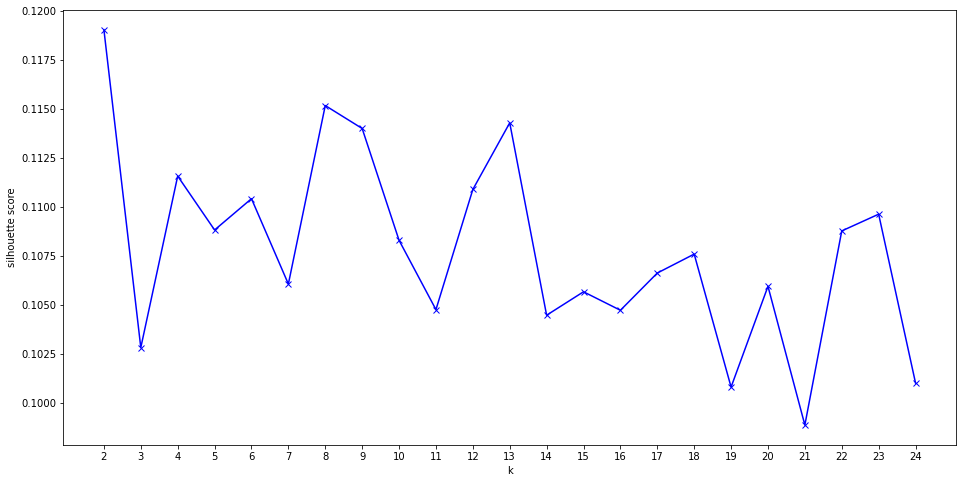

In [14]:
#applying silhouette to see how many clusters is a good number to apply

K = range(2,25)

song_data = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(numericals_big_boi_frame)
    song_data.append(silhouette_score(numericals_big_boi_frame, kmeans.predict(numericals_big_boi_frame)))


plt.figure(figsize=(16,8))
plt.plot(K, song_data, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.show()

In [15]:
#applying the clustering

kmeans = KMeans(n_clusters=23, random_state=42)
kmeans.fit(numericals_big_boi_frame)

C:\Users\parag\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


KMeans(n_clusters=23, random_state=42)

In [16]:
# Predicting / assigning the clusters:
clusters = kmeans.predict(numericals_big_boi_frame)
clusters

array([ 1, 21,  4, 15, 13,  8, 11, 11, 15,  8, 21, 19, 22,  3,  6,  9,  6,
        8,  8, 21, 17,  7, 22,  0, 19, 15, 21,  3, 21, 11,  7,  8, 15,  2,
       13, 21, 15,  2, 21, 15, 22,  7,  7, 12, 13, 14,  9,  4, 21, 18, 13,
       18,  4, 22, 21,  8, 18, 21,  6, 11, 11,  4, 19, 12, 14,  3, 19, 19,
        2, 17, 13,  7, 12, 12,  7,  3, 14, 14,  2, 21,  0,  8,  0,  4, 21,
        1,  6, 13, 13,  6, 13, 11,  1, 10,  7,  8, 13,  8, 13, 15,  2, 19,
        0, 14,  7, 20, 14,  7, 21, 21, 15, 11, 19, 13,  0, 15, 15,  0,  0,
       21, 21, 11, 14, 10,  4,  2,  7, 17, 10,  8, 11,  7,  2,  8, 17,  0,
        9,  0,  3, 11, 21, 15,  2, 19,  8, 15,  3, 21, 21,  1,  9,  1,  6,
       11,  0,  1,  0, 21, 13, 11,  3,  3,  4, 21, 11,  9, 22,  4,  4,  4,
        4,  2, 18, 14,  8,  6,  9,  0,  7,  4, 15, 13,  7, 13, 13, 17,  5,
        6,  1,  9,  4,  4, 15, 19,  6,  6, 12, 15, 19,  7, 14,  8,  9,  9,
       17,  7, 17, 10,  8, 17,  1,  9,  0,  1, 18, 14,  2, 14,  3,  9, 14,
       15,  0, 22, 12,  6

In [17]:
#assigning the clusters to the main final df
the_big_boi_frame["clusters"] = clusters

In [18]:
# Check the size of the clusters
pd.Series(clusters).value_counts().sort_index()

0     16
1     17
2     27
3     17
4     20
5      2
6     24
7     20
8     31
9     21
10     8
11    16
12    14
13    20
14    20
15    30
16     2
17    17
18    13
19    13
20     1
21    33
22    14
dtype: int64

In [19]:
the_big_boi_frame.groupby(['clusters','genre'], as_index=False).count().sort_values(['clusters', 'key'], ascending=[True, False])[['genre', 'clusters', 'key']].reset_index(drop=True).groupby(["clusters"]).head(3)

,genre,clusters,key
0,classic bollywood,0,12
1,afghan pop,0,2
2,genreless,0,2
3,desi pop,1,9
4,classic bollywood,1,4
...,...,...,...
94,desi pop,21,8
95,afghan pop,21,5
101,desi pop,22,8
102,classic bollywood,22,3


In [20]:
the_big_boi_frame = the_big_boi_frame.reset_index(drop=True)

In [21]:
#getting song and recomending song kinda here
def recomend_song():
    song_name = input("Choose a song: ")
    results = sp.search(q=f'track:{song_name}', limit=1)
    track_id = results['tracks']['items'][0]['id'] if results['tracks']['items'] else None
    while not track_id:
        return recomend_song()
    # get song features with the obtained id
    audio_features = sp.audio_features(track_id)
    #get song popularity and genre
    song_pop_genre = sp.artist(results['tracks']["items"][0]["album"]["artists"][0]["external_urls"]["spotify"])
    the_genre = song_pop_genre["genres"][0] if song_pop_genre["genres"] else "generless"
    the_pop = song_pop_genre["popularity"]
    #create the df
    df_uni_song = pd.DataFrame(audio_features)
    df_uni_song["popularity"] = the_pop
    #merge the datas
    new_features = df_uni_song[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','popularity']]
    df_uni_song["genre"] = the_genre
    #scale features
    #scaler = StandardScaler()
    scaled_x = scaler.transform(new_features)
    
    # predict cluster
    cluster = kmeans.predict(scaled_x)
    # filter dataset to predicted cluster
    filtered_df = the_big_boi_frame[the_big_boi_frame['clusters'] == cluster[0]][new_features.columns]
    # get closest song from filtered dataset
    closest, _ = pairwise_distances_argmin_min(np.array(scaled_x).copy(order="C"),np.array(filtered_df).copy(order="C"))
    # return it in a readable way
    print('\n [RECOMMENDED SONG]')
    return ' - '.join([the_big_boi_frame.loc[closest]['song_name'].values[0], the_big_boi_frame.loc[closest]['artists'].values[0]])

In [24]:
recomend_song()


Choose a song: desi boyz

 [RECOMMENDED SONG]


'Ae Kash Ke Hum - Jatin-Lalit'